ref:https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/self_query/

# Self-querying

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to its underlying VectorStore. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documents but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

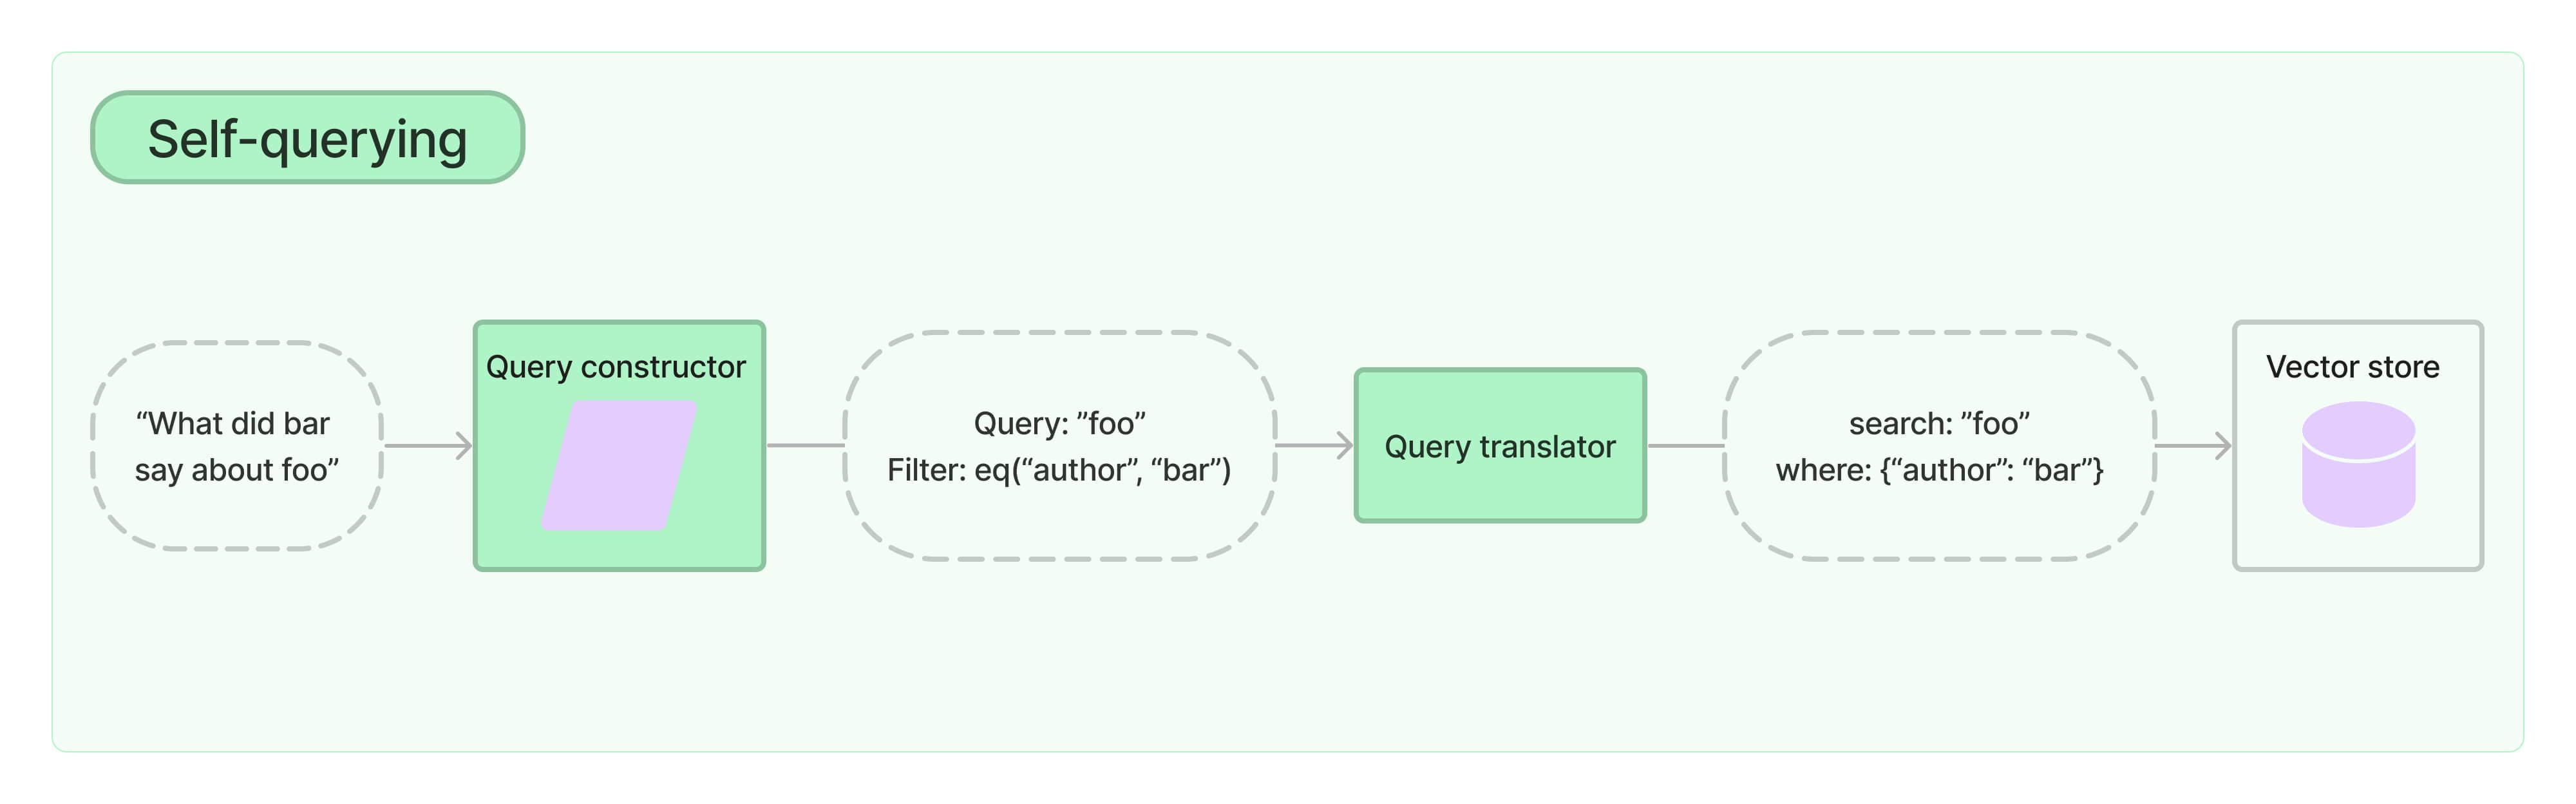

## Get started
For demonstration purposes we'll use a Chroma vector store.

We've created a small demo set of documents that contain summaries of movies.

Note: The self-query retriever requires you to have lark package installed.

In [1]:
from langchain.vectorstores.chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]
vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

## Creating our self-querying retriever
Now we can instantiate our retriever.

To do this we'll need to provide some information upfront about the metadata fields that our documents support and a short description of the document contents.

In [2]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating",
        description="A 1-10 rating for the movie",
        type="float"
    ),
]
document_content_description = "Brief summary of a movie"
llm = ChatOpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)

## Testing it out
And now we can actually try using our retriever!

In [3]:
# This example only specifies a filter
retriever.invoke("I want to watch a movie rated higher than 8.5")

[Document(page_content='Three men walk into the Zone, three men walk out of the Zone', metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979}),
 Document(page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea', metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'year': 2006})]

In [4]:
# This example specifies a query and a filter
retriever.invoke("Has Greta Gerwig directed any movies about women")

[Document(page_content='A bunch of normal-sized women are supremely wholesome and some men pine after them', metadata={'director': 'Greta Gerwig', 'rating': 8.3, 'year': 2019})]

In [5]:
# This example specifies a composite filter
retriever.invoke("What's a highly rated (above 8.5) science fiction film?")

[Document(page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea', metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'year': 2006}),
 Document(page_content='Three men walk into the Zone, three men walk out of the Zone', metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979})]

In [6]:
# This example specifies a query and composite filter
retriever.invoke(
    "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
)

[Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]

## Filter k
We can also use the self query retriever to specify `k`: the number of documents to fetch.

We can do this by passing `enable_limit=True` to the constructor.



In [7]:
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
    enable_limit=True,
)

# This example only specifies a relevant query
retriever.invoke("What are two movies about dinosaurs")

[Document(page_content='A bunch of scientists bring back dinosaurs and mayhem breaks loose', metadata={'genre': 'science fiction', 'rating': 7.7, 'year': 1993}),
 Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]

# Constructing from scratch with LCEL
To see what's going on under the hood, and to have more custom control,  
we can reconstruct our retriever from scratch.

First, we need to create a query-construction chain.  
This chain will take a user query and generated a StructuredQuery object which captures the filters specified by the user.  
We provide some helper functions for creating a prompt and output parser.  
These have a number of tunable params that we'll ignore here for simplicity.

In [9]:
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt,
)

# document_content_description = "Brief summary of a movie"
# see above

prompt = get_query_constructor_prompt(
    document_content_description,
    metadata_field_info,
)
output_parser = StructuredQueryOutputParser.from_components()
query_constructor = prompt | llm | output_parser

In [10]:
print(prompt.format(query="dummy question"))

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: comp(attr, val):

comp (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
attr (string): name of attribute to apply the comparison to
val (string): is the comparison value
A logical operation statement takes the form op(statement1, statement2, ...):

op (and | or | not): logical operator
statement1, statement2, ... (comparison statements or logical operation statements): one or more statements to apply the operation to
Make sure that you only use the comparators and logical operators listed above and no others. Make sure that filters only refer to attributes that exist in the data source. Make sure that filters only use the attributed names with its function names if there are functions applied on them. Make sure that filters only use format YYYY-MM-DD when handling date data typed values. Make sure that filters take into account the descriptions of attributes and only make comparisons that are feasible given the type of data being stored. Make sure that filters are only used as needed. If there are no filters that should be applied return "NO_FILTER" for the filter value.

<< Example 1. >> Data Source:

{
    "content": "Lyrics of a song",
    "attributes": {
        "artist": {
            "type": "string",
            "description": "Name of the song artist"
        },
        "length": {
            "type": "integer",
            "description": "Length of the song in seconds"
        },
        "genre": {
            "type": "string",
            "description": "The song genre, one of "pop", "rock" or "rap""
        }
    }
}

User Query: What are songs by Taylor Swift or Katy Perry about teenage romance under 3 minutes long in the dance pop genre

Structured Request:

{
    "query": "teenager love",
    "filter": "and(or(eq(\"artist\", \"Taylor Swift\"), eq(\"artist\", \"Katy Perry\")), lt(\"length\", 180), eq(\"genre\", \"pop\"))"
}

<< Example 2. >> Data Source:

{
    "content": "Lyrics of a song",
    "attributes": {
        "artist": {
            "type": "string",
            "description": "Name of the song artist"
        },
        "length": {
            "type": "integer",
            "description": "Length of the song in seconds"
        },
        "genre": {
            "type": "string",
            "description": "The song genre, one of "pop", "rock" or "rap""
        }
    }
}

User Query: What are songs that were not published on Spotify

Structured Request:

{
    "query": "",
    "filter": "NO_FILTER"
}

<< Example 3. >> Data Source:

{
    "content": "Brief summary of a movie",
    "attributes": {
    "genre": {
        "description": "The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        "type": "string"
    },
    "year": {
        "description": "The year the movie was released",
        "type": "integer"
    },
    "director": {
        "description": "The name of the movie director",
        "type": "string"
    },
    "rating": {
        "description": "A 1-10 rating for the movie",
        "type": "float"
    }
}
}

User Query: dummy question

Structured Request:

And what our full chain produces:


```python
query_constructor.invoke(
    {
        "query": "What are some sci-fi movies from the 90's directed by Luc Besson about taxi drivers"
    }
)

StructuredQuery(query='taxi driver', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='genre', value='science fiction'), Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='year', value=1990), Comparison(comparator=<Comparator.LT: 'lt'>, attribute='year', value=2000)]), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='director', value='Luc Besson')]), limit=None)

The query constructor is the key element of the self-query retriever. To make a great retrieval system you'll need to make sure your query constructor works well. Often this requires adjusting the prompt, the examples in the prompt, the attribute descriptions, etc. For an example that walks through refining a query constructor on some hotel inventory data, check out this cookbook.

The next key element is the structured query translator. This is the object responsible for translating the generic StructuredQuery object into a metadata filter in the syntax of the vector store you're using. LangChain comes with a number of built-in translators. To see them all head to the Integrations section.

In [11]:
from langchain.retrievers.self_query.chroma import ChromaTranslator

retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vectorstore,
    structured_query_translator=ChromaTranslator(),
)

In [12]:
retriever.invoke(
    "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
)

[Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]